# Introduction
In this notebook, we perform a thorough exploratory data analysis of the titles and interactions datasets to understand the data's structure, identify any issues, and prepare it for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load titles data
titles = pd.read_csv('titles.csv.gz', compression='gzip', low_memory=False)
print("Titles Data Loaded Successfully!")


Titles Data Loaded Successfully!


In [3]:
# Load interactions data
interactions = pd.read_csv('title_interactions.csv.gz', compression='gzip', low_memory=False)
print("Interactions Data Loaded Successfully!")


Interactions Data Loaded Successfully!


## Data Overview

In [4]:
# Display first few rows
titles.head()


,TITLE_ID,ORIGINAL_TITLE,ORIGINAL_LANGUAGE,RELEASE_DURATION_DAYS,GENRE_TMDB,DIRECTOR,ACTOR,PRODUCER,WRITER
0,tm1282307,L'ultima notte di Amore,it,484,"[\n ""drama"",\n ""thriller""\n]","[\n ""Andrea Di Stefano""\n]","[\n ""Pierfrancesco Favino"",\n ""Linda Caridi""...","[\n ""Benedetto Habib"",\n ""Daniel Campos Pavo...",NaN
1,tm1338500,Bird Box Barcelona,es,357,"[\n ""horror"",\n ""scifi"",\n ""thriller""\n]","[\n ""David Pastor"",\n ""Àlex Pastor""\n]","[\n ""Mario Casas"",\n ""Georgina Campbell"",\n ...","[\n ""Adrián Guerra"",\n ""Chris Morgan"",\n ""D...","[\n ""David Pastor"",\n ""Àlex Pastor""\n]"
2,ts371824,Steeltown Murders,en,417,"[\n ""crime"",\n ""drama"",\n ""history"",\n ""th...","[\n ""Marc Evans""\n]","[\n ""Scott Arthur"",\n ""Sion Alun Davies"",\n ...","[\n ""Hannah Thomas""\n]","[\n ""Ed Whitmore""\n]"
3,tm123363,Expend4bles,en,294,"[\n ""action"",\n ""thriller"",\n ""war""\n]","[\n ""Scott Waugh""\n]","[\n ""Jason Statham"",\n ""Sylvester Stallone"",...","[\n ""Jason Statham"",\n ""Jeffrey Greenstein"",...",NaN
4,tm1045025,65,en,491,"[\n ""action"",\n ""drama"",\n ""scifi"",\n ""thr...","[\n ""Bryan Woods"",\n ""Scott Beck""\n]","[\n ""Adam Driver"",\n ""Ariana Greenblatt"",\n ...","[\n ""Bryan Woods"",\n ""Deborah Liebling"",\n ...","[\n ""Bryan Woods"",\n ""Scott Beck""\n]"


In [5]:
# Check data info
titles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20629 entries, 0 to 20628
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   TITLE_ID               20629 non-null  object
 1   ORIGINAL_TITLE         20628 non-null  object
 2   ORIGINAL_LANGUAGE      20510 non-null  object
 3   RELEASE_DURATION_DAYS  20629 non-null  int64 
 4   GENRE_TMDB             20607 non-null  object
 5   DIRECTOR               20347 non-null  object
 6   ACTOR                  20010 non-null  object
 7   PRODUCER               20144 non-null  object
 8   WRITER                 7340 non-null   object
dtypes: int64(1), object(8)
memory usage: 1.4+ MB


In [6]:
# Display first few rows
interactions.head()


,BE_ID,TITLE_ID,COLLECTOR_TSTAMP,INTERACTION_TYPE
0,89ce5486cfd135f81edd5f2cc4013e1e,tm122846,2024-04-06T21:37:50.666Z,clickout_provider
1,5437456587e85d0b97070ea63f459e49,tm172163,2024-04-07T02:08:27.618Z,seenlist_addition
2,98c21bf80a45fbfef9902508aba52cdc,ts22280,2024-04-14T05:23:09.304Z,seenlist_addition
3,a4fe1d6790b12ef00f5a81631b69a437,ts416258,2024-04-07T07:34:54.506Z,seenlist_addition
4,69cf67f4676a77d6ead478f60d84a493,ts15366,2024-04-08T08:29:22.511Z,seenlist_addition


In [7]:
# Check data info
interactions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11534161 entries, 0 to 11534160
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   BE_ID             object
 1   TITLE_ID          object
 2   COLLECTOR_TSTAMP  object
 3   INTERACTION_TYPE  object
dtypes: object(4)
memory usage: 352.0+ MB


## Data Cleaning

In [8]:
# Check for missing values
titles.isnull().sum()


TITLE_ID                     0
ORIGINAL_TITLE               1
ORIGINAL_LANGUAGE          119
RELEASE_DURATION_DAYS        0
GENRE_TMDB                  22
DIRECTOR                   282
ACTOR                      619
PRODUCER                   485
WRITER                   13289
dtype: int64

In [9]:
# Drop 'WRITER' column
titles.drop(columns=['WRITER'], inplace=True)

# Fill missing values with 'Unknown' for categorical columns
titles['ORIGINAL_TITLE'].fillna('Unknown', inplace=True)
titles['ORIGINAL_LANGUAGE'].fillna('Unknown', inplace=True)
titles['GENRE_TMDB'].fillna('Unknown', inplace=True)
titles['DIRECTOR'].fillna('Unknown', inplace=True)
titles['ACTOR'].fillna('Unknown', inplace=True)
titles['PRODUCER'].fillna('Unknown', inplace=True)


In [10]:
def parse_multivalued_column(column):
    if column == 'Unknown':
        return ['Unknown']
    else:
        return [x.strip() for x in column.strip('[]').replace('"', '').split(',') if x.strip()]
        
multivalued_columns = ['GENRE_TMDB', 'DIRECTOR', 'ACTOR', 'PRODUCER']
for col in multivalued_columns:
    titles[col] = titles[col].apply(parse_multivalued_column)


In [11]:
titles['RELEASE_DURATION_DAYS'] = pd.to_numeric(titles['RELEASE_DURATION_DAYS'], errors='coerce')

In [12]:
# Set negative values to NaN
titles.loc[titles['RELEASE_DURATION_DAYS'] < 0, 'RELEASE_DURATION_DAYS'] = np.nan

# Fill missing values with the mean or median
titles['RELEASE_DURATION_DAYS'].fillna(titles['RELEASE_DURATION_DAYS'].median(), inplace=True)


## Exploratory Data Analysis

### Titles Dataset Analysis

#### Genre Distribution

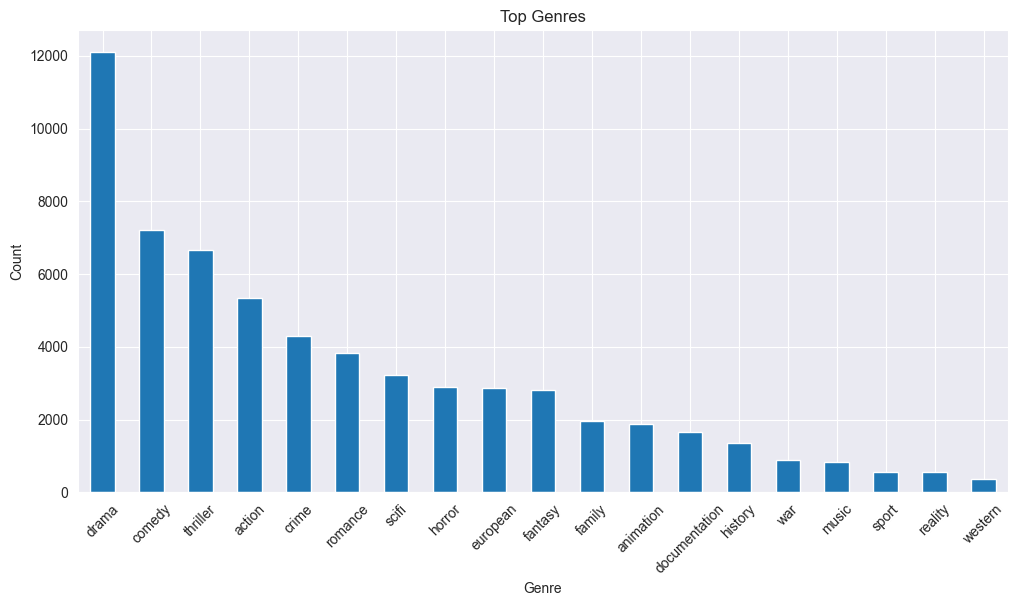

In [13]:
# Explode genres
genres_exploded = titles.explode('GENRE_TMDB')
genre_counts = genres_exploded['GENRE_TMDB'].value_counts().drop('Unknown')

# Plot top genres
plt.figure(figsize=(12,6))
genre_counts.head(20).plot(kind='bar')
plt.title('Top Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [14]:
genres_exploded['GENRE_TMDB'].value_counts(normalize=True)

GENRE_TMDB
drama            0.197258
comedy           0.117706
thriller         0.108754
action           0.087069
crime            0.070095
romance          0.062269
scifi            0.052420
horror           0.047138
european         0.046942
fantasy          0.045866
family           0.032170
animation        0.030784
documentation    0.026952
history          0.022077
war              0.014577
music            0.013435
sport            0.009294
reality          0.008968
western          0.005870
Unknown          0.000359
Name: proportion, dtype: float64

#### Language Distribution

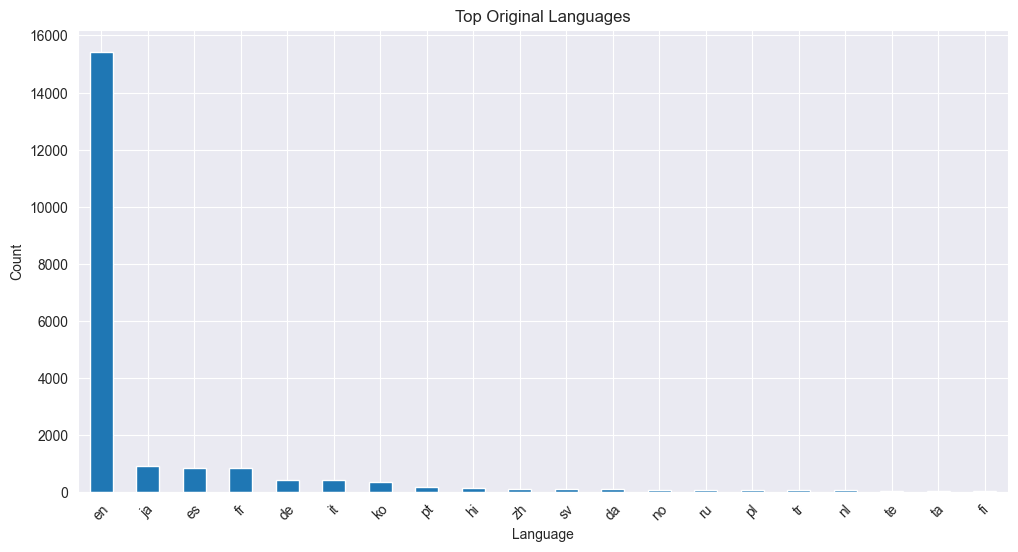

In [15]:
language_counts = titles['ORIGINAL_LANGUAGE'].value_counts().drop('Unknown')

plt.figure(figsize=(12,6))
language_counts.head(20).plot(kind='bar')
plt.title('Top Original Languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [16]:
titles['ORIGINAL_LANGUAGE'].value_counts(normalize=True)

ORIGINAL_LANGUAGE
en    0.747782
ja    0.044064
es    0.041350
fr    0.040235
de    0.020214
        ...   
sh    0.000048
mi    0.000048
gu    0.000048
bs    0.000048
as    0.000048
Name: proportion, Length: 67, dtype: float64

#### Directors


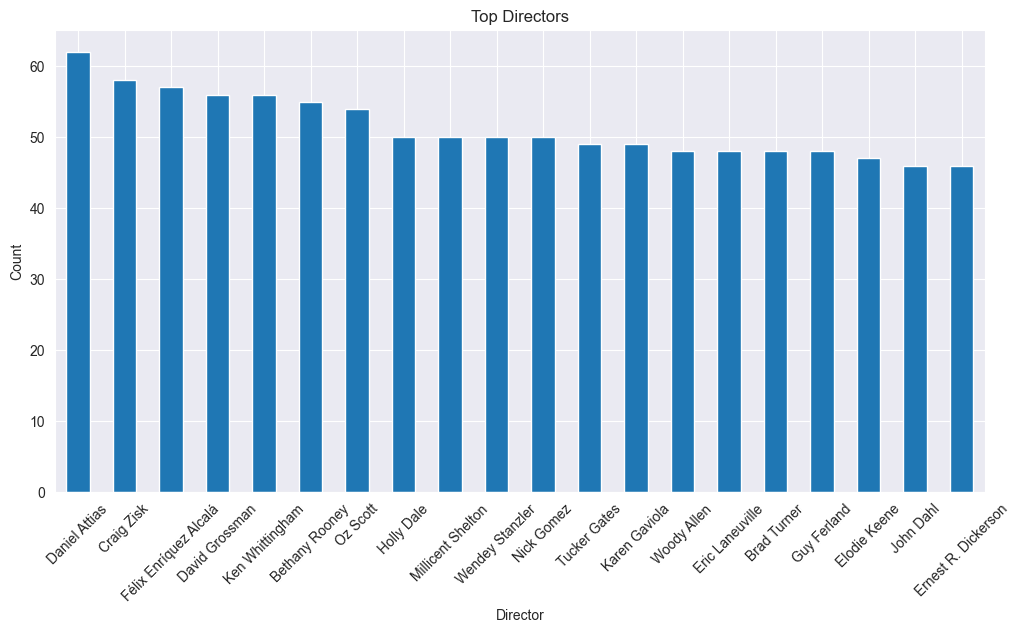

In [17]:
# Explode directors
directors_exploded = titles.explode('DIRECTOR')
director_counts = directors_exploded['DIRECTOR'].value_counts().drop('Unknown')

# Plot top directors
plt.figure(figsize=(12,6))
director_counts.head(20).plot(kind='bar')
plt.title('Top Directors')
plt.xlabel('Director')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [18]:
directors_exploded['DIRECTOR'].value_counts(normalize=True)

DIRECTOR
Unknown                  0.004436
Daniel Attias            0.000975
Craig Zisk               0.000912
Félix Enríquez Alcalá    0.000897
David Grossman           0.000881
                           ...   
Guy Davidi               0.000016
Joann Sfar               0.000016
Stephen Fingleton        0.000016
Jason Zada               0.000016
Seymour Kneitel          0.000016
Name: proportion, Length: 23584, dtype: float64

#### Actors

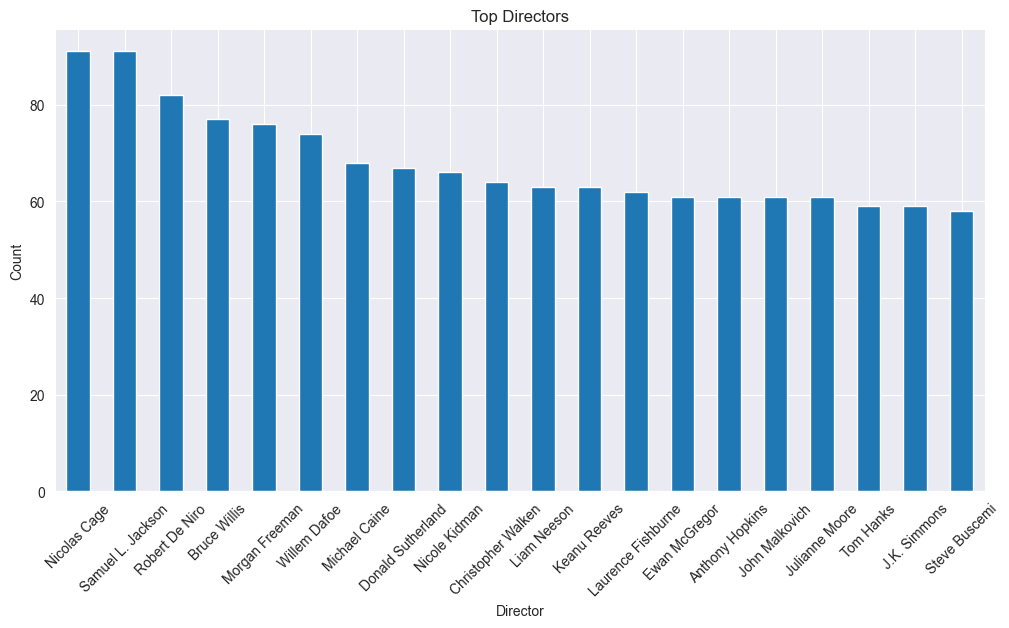

In [19]:
# Explode directors
actors_exploded = titles.explode('ACTOR')
actor_counts = actors_exploded['ACTOR'].value_counts().drop('Unknown')

# Plot top directors
plt.figure(figsize=(12,6))
actor_counts.head(20).plot(kind='bar')
plt.title('Top Directors')
plt.xlabel('Director')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [20]:
actors_exploded['ACTOR'].value_counts(normalize=True)

ACTOR
Unknown               0.003522
Nicolas Cage          0.000518
Samuel L. Jackson     0.000518
Robert De Niro        0.000467
Bruce Willis          0.000438
                        ...   
Charles Craig         0.000006
S. William Hinzman    0.000006
Bill Cardille         0.000006
Max Montesi           0.000006
Jeffrey Broadhurst    0.000006
Name: proportion, Length: 73174, dtype: float64

#### Producer

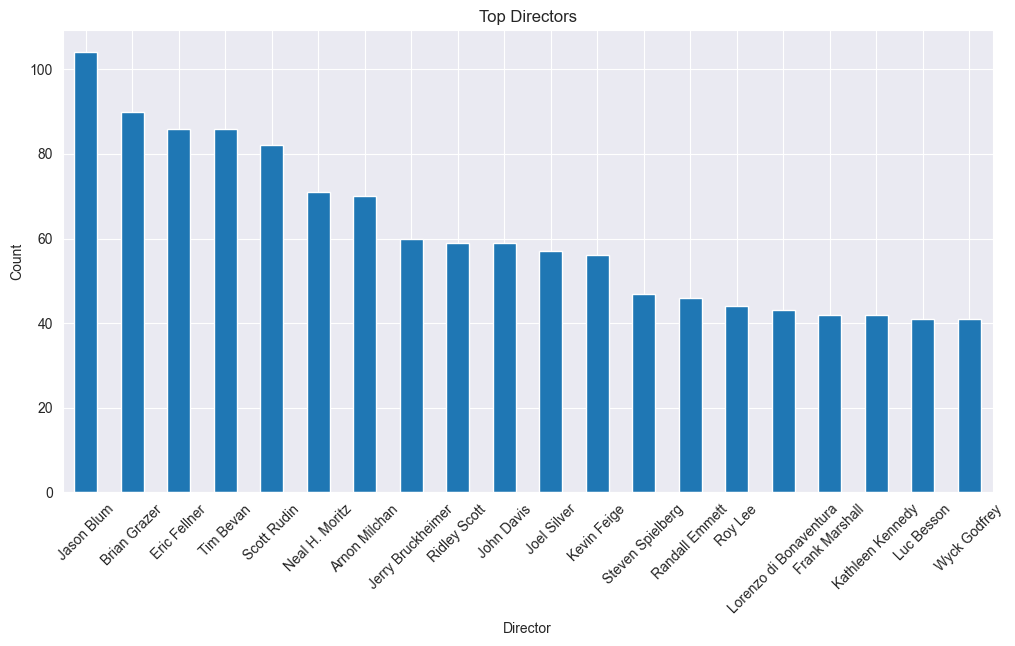

In [21]:
# Explode directors
producers_exploded = titles.explode('PRODUCER')
producer_counts = producers_exploded['PRODUCER'].value_counts().drop('Unknown')

# Plot top directors
plt.figure(figsize=(12,6))
producer_counts.head(20).plot(kind='bar')
plt.title('Top Directors')
plt.xlabel('Director')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [22]:
producers_exploded['PRODUCER'].value_counts(normalize=True)

PRODUCER
Unknown             0.003914
Jason Blum          0.000839
Brian Grazer        0.000726
Eric Fellner        0.000694
Tim Bevan           0.000694
                      ...   
Michiko Takahisa    0.000008
Bo Juhl Nielsen     0.000008
Al Shier            0.000008
Lewis Telfer        0.000008
Emile Ardolino      0.000008
Name: proportion, Length: 64502, dtype: float64

## Interactions Dataset Analysis

#### Interaction Types Distribution

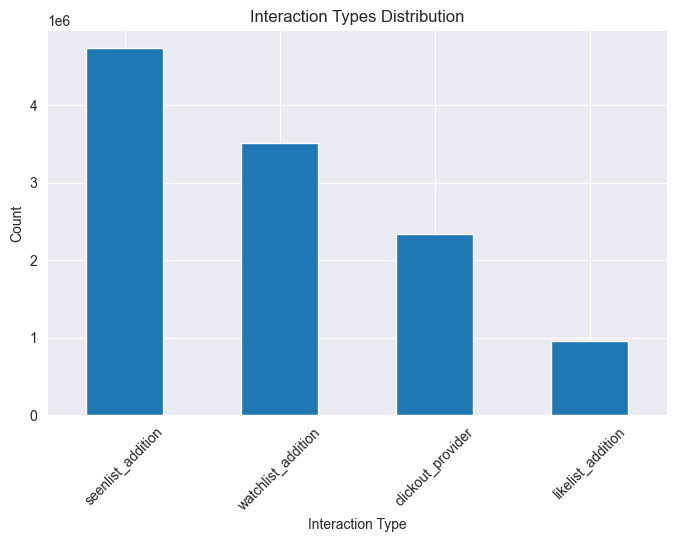

In [23]:
interaction_counts = interactions['INTERACTION_TYPE'].value_counts()

plt.figure(figsize=(8,5))
interaction_counts.plot(kind='bar')
plt.title('Interaction Types Distribution')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


#### Interaction Types Distribution

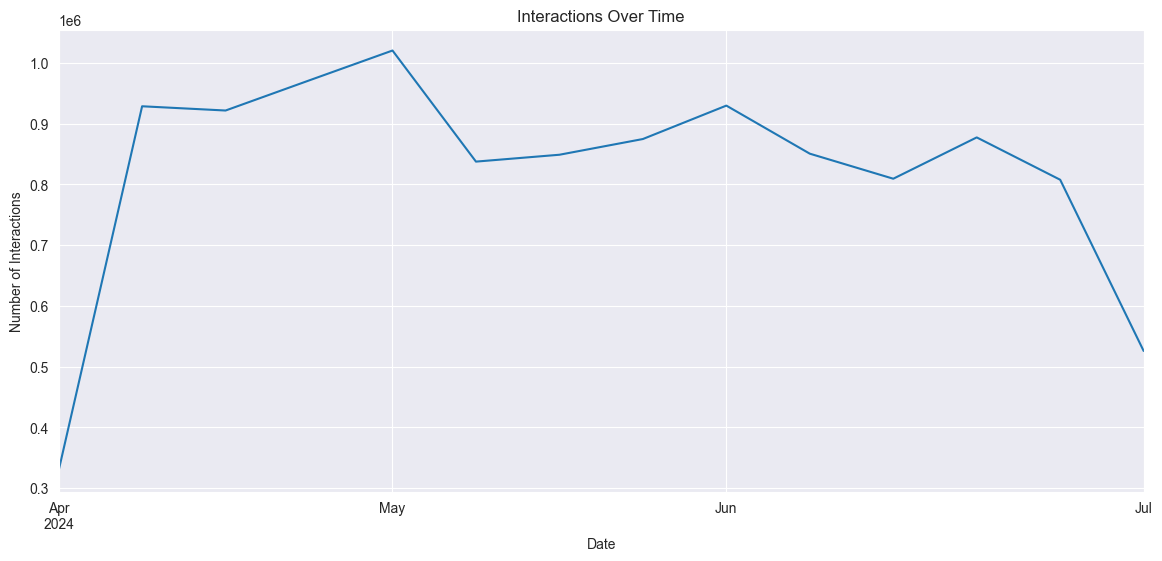

In [24]:
# Convert 'COLLECTOR_TSTAMP' to datetime
interactions['COLLECTOR_TSTAMP'] = pd.to_datetime(interactions['COLLECTOR_TSTAMP'])

# Plot number of interactions over time
interactions.set_index('COLLECTOR_TSTAMP').resample('W')['BE_ID'].count().plot(figsize=(14,6))
plt.title('Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()


#### Most Interacted Titles

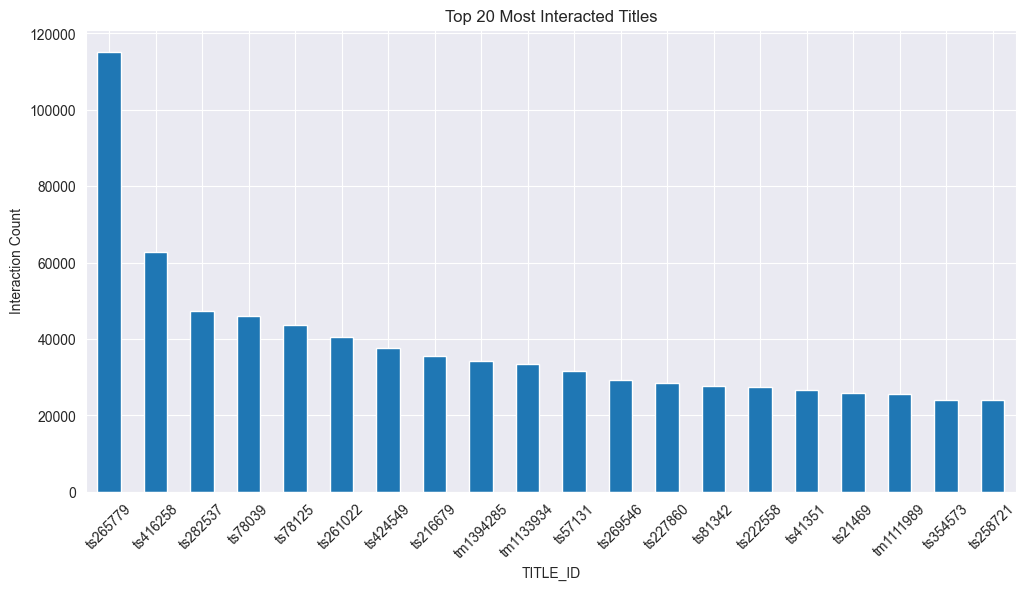

In [25]:
title_interactions = interactions['TITLE_ID'].value_counts()

# Plot top 20 most interacted titles
plt.figure(figsize=(12,6))
title_interactions.head(20).plot(kind='bar')
plt.title('Top 20 Most Interacted Titles')
plt.xlabel('TITLE_ID')
plt.ylabel('Interaction Count')
plt.xticks(rotation=45)
plt.show()


## User Interaction Analysis

#### Interactions per User

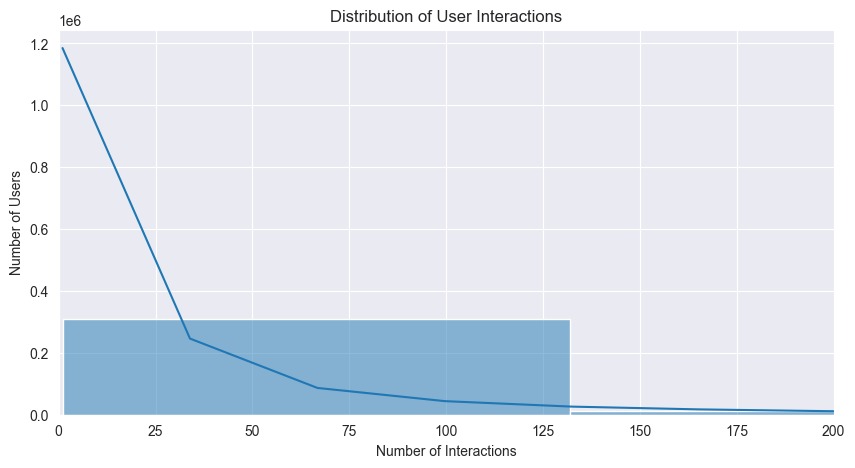

In [26]:
user_interactions = interactions['BE_ID'].value_counts()

# Plot distribution of user interactions
plt.figure(figsize=(10,5))
sns.histplot(user_interactions, bins=50, kde=True)
plt.title('Distribution of User Interactions')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.xlim(0, 200)  # Limit x-axis for better visualization
plt.show()


#### Average Interactions per User

In [27]:
print(f"Average interactions per user: {user_interactions.mean():.2f}")

Average interactions per user: 35.04


## Feature Importance Analysis
To understand which features are more important for predicting user interactions, we'll perform a coefficient analysis using a logistic regression model.

### Create Interaction Count per Title

In [31]:
# Count the number of interactions per TITLE_ID
title_interaction_counts = interactions['TITLE_ID'].value_counts().reset_index()
title_interaction_counts.columns = ['TITLE_ID', 'INTERACTION_COUNT']

# Merge with titles data
titles_merged = titles.merge(title_interaction_counts, on='TITLE_ID', how='left')

# Fill NaN interaction counts with 0
titles_merged['INTERACTION_COUNT'].fillna(0, inplace=True)

# Calculate median interaction count
median_interaction = titles_merged['INTERACTION_COUNT'].median()

# Create binary target variable
titles_merged['POPULAR'] = np.where(titles_merged['INTERACTION_COUNT'] >= median_interaction, 1, 0)


### Create Target Variable
We'll create a binary target variable where:

1 indicates a popular title (interaction count above median).
0 indicates a less popular title.

In [32]:
from sklearn.preprocessing import MultiLabelBinarizer

# Define a function to get top N items
def get_top_n_items(column, n):
    all_items = titles_merged.explode(column)[column]
    top_n = all_items.value_counts().nlargest(n).index.tolist()
    return top_n

# Limit the number of unique categories for each multivalued feature
top_n_genres = get_top_n_items('GENRE_TMDB', n=20)
top_n_directors = get_top_n_items('DIRECTOR', n=50)
top_n_actors = get_top_n_items('ACTOR', n=100)
top_n_producers = get_top_n_items('PRODUCER', n=50)

# Replace less frequent items with 'other'
def limit_categories(items, top_n):
    return [item if item in top_n else 'other' for item in items]

titles_merged['GENRE_TMDB'] = titles_merged['GENRE_TMDB'].apply(lambda x: limit_categories(x, top_n_genres))
titles_merged['DIRECTOR'] = titles_merged['DIRECTOR'].apply(lambda x: limit_categories(x, top_n_directors))
titles_merged['ACTOR'] = titles_merged['ACTOR'].apply(lambda x: limit_categories(x, top_n_actors))
titles_merged['PRODUCER'] = titles_merged['PRODUCER'].apply(lambda x: limit_categories(x, top_n_producers))

# Now proceed with encoding
def encode_multivalued_feature(df, column):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[column])
    encoded_df = pd.DataFrame(encoded, columns=[f"{column}_{cls}" for cls in mlb.classes_])
    return encoded_df

# Encode GENRE_TMDB
genre_encoded = encode_multivalued_feature(titles_merged, 'GENRE_TMDB')

# Encode DIRECTOR
director_encoded = encode_multivalued_feature(titles_merged, 'DIRECTOR')

# Encode ACTOR
actor_encoded = encode_multivalued_feature(titles_merged, 'ACTOR')

# Encode PRODUCER
producer_encoded = encode_multivalued_feature(titles_merged, 'PRODUCER')

# One-hot encode ORIGINAL_LANGUAGE (you may also limit languages if necessary)
language_counts = titles_merged['ORIGINAL_LANGUAGE'].value_counts()
top_languages = language_counts.nlargest(10).index.tolist()
titles_merged['ORIGINAL_LANGUAGE'] = titles_merged['ORIGINAL_LANGUAGE'].apply(lambda x: x if x in top_languages else 'other')

language_encoded = pd.get_dummies(titles_merged['ORIGINAL_LANGUAGE'], prefix='LANG')

# Combine all encoded features
features = pd.concat([
    genre_encoded,
    director_encoded,
    actor_encoded,
    producer_encoded,
    language_encoded,
    titles_merged[['RELEASE_DURATION_DAYS']]
], axis=1)


In [33]:
# Target variable
y = titles_merged['POPULAR']

# Features
X = features

# Due to computational constraints, we may sample the data
# Sample 5000 instances
X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=5000, stratify=y, random_state=42)

# Further split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled, random_state=42)


In [34]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Train the model
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate ROC AUC score
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")



Accuracy: 0.6270
ROC AUC Score: 0.6824


In [37]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Calculate ROC AUC score
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Random Forest ROC AUC Score: {roc_auc_rf:.4f}")


Random Forest Accuracy: 0.5750
Random Forest ROC AUC Score: 0.6049


### Analyzing Feature Importance

In [35]:
# Get feature names
feature_names = X_train.columns

# Get coefficients
coefficients = logreg.coef_[0]

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Get absolute values for sorting
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Top 20 positive features
top_positive = coef_df_sorted[coef_df_sorted['Coefficient'] > 0].head(20)

# Top 20 negative features
top_negative = coef_df_sorted[coef_df_sorted['Coefficient'] < 0].head(20)


In [39]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importances_df_sorted = importances_df.sort_values(by='Importance', ascending=False)

importances_df_sorted

,Feature,Importance
234,RELEASE_DURATION_DAYS,0.403940
6,GENRE_TMDB_drama,0.029612
3,GENRE_TMDB_comedy,0.027943
225,LANG_en,0.024399
14,GENRE_TMDB_romance,0.023039
...,...,...
66,DIRECTOR_Tucker Gates,0.000246
172,PRODUCER_Adrian Politowski,0.000222
21,DIRECTOR_Adam Davidson,0.000193
181,PRODUCER_Clint Eastwood,0.000192


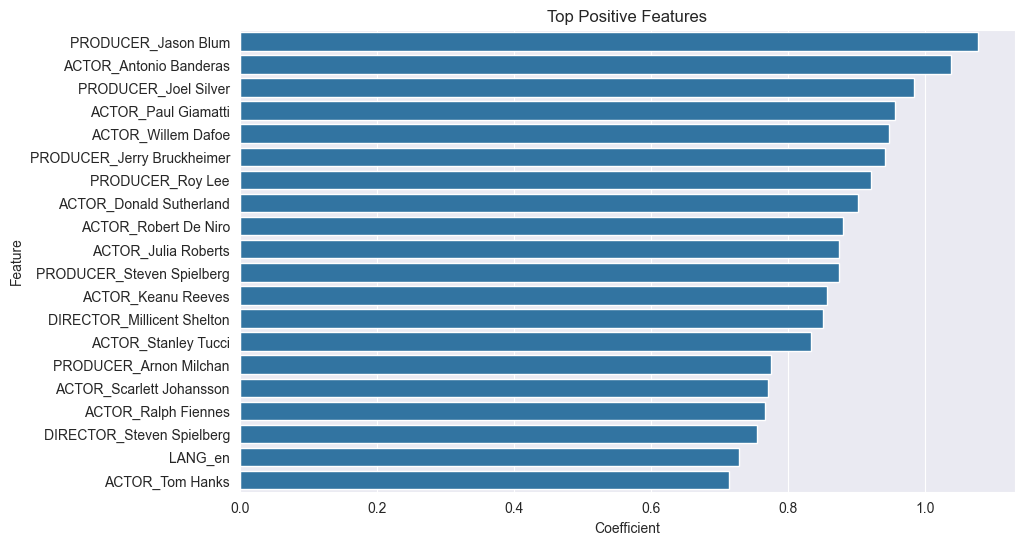

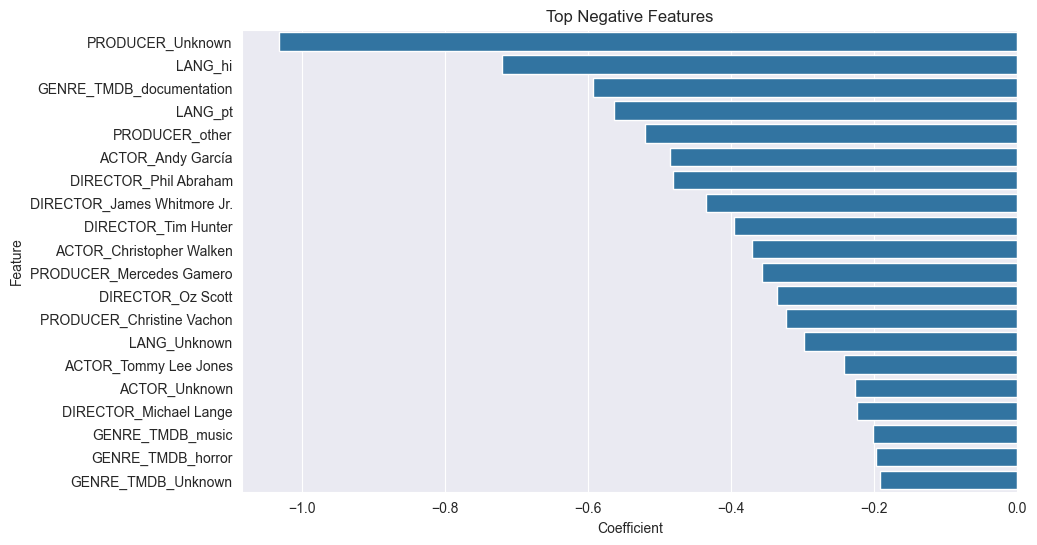

In [36]:
# Plot top positive features
plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=top_positive)
plt.title('Top Positive Features')
plt.show()

# Plot top negative features
plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=top_negative)
plt.title('Top Negative Features')
plt.show()


## Data Preparation for Modeling

In [36]:
# Save cleaned data
# titles.to_csv('titles_cleaned.csv', index=False)
# interactions.to_csv('interactions_cleaned.csv', index=False)